In [9]:
import pandas as pd
import numpy as np
import spectral_library # * all major functions have been moved here
import matplotlib.pyplot as plt
import sklearn

In [2]:
df = spectral_library.open_file("unmixing/original_data.csv")

# Generating Distance Matrixes

In [3]:
wavelengths = spectral_library.wavelength_columns(df)

In [4]:
npv_fractions, numeric_data,_ = spectral_library.take_subset(df,int(wavelengths[0]),int(wavelengths[-1]))

In [5]:
magnitudes = np.fromiter((np.linalg.norm(numeric_data.loc[row_i]) for row_i in range(0,numeric_data.shape[0])), dtype="float")

In [ ]:
plt.xlabel("Magnitudes")
plt.ylabel("Count")
plt.title(f"Magnitudes of {df.shape[0]} vectors ({wavelengths[0]}nm to {wavelengths[-1]}nm)")
plt.hist(magnitudes,bins=60)
print()

In [ ]:
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(magnitudes, npv_fractions, test_size=0.2, random_state=42)
coefficients = np.polyfit(train_X,train_y,1)
print("Coefficients",coefficients)
print("Linear Regression on Magnitudes")
y_predicted_validation = np.polyval(coefficients,validate_X)
r2 = np.mean((y_predicted_validation - validate_y.to_numpy())**2)
print(r2)

In [1]:
plt.scatter(x=y_predicted_validation,y=validate_y)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted by LinearReg vs Actual on Validation")
print()

NameError: name 'plt' is not defined

In [37]:
df['magnitudes'] = magnitudes

In [ ]:
sorted_df = df.sort_values(by='magnitudes')

In [57]:
_, numeric_data_sorted, _ = spectral_library.take_subset(sorted_df,int(wavelengths[0]),int(wavelengths[-1]))

In [5]:
def angle(spectrum_1,spectrum_2):
    dot_product = np.dot(spectrum_1, spectrum_2)
    magnitude_1 = np.linalg.norm(spectrum_1)
    magnitude_2 = np.linalg.norm(spectrum_2)
    cosine_angle = dot_product / (magnitude_1 * magnitude_2)
    spectral_angle = np.arccos(cosine_angle)
    return spectral_angle

def euclidean(spectra_1,spectra_2):
    return np.linalg.norm(spectra_1-spectra_2)

In [6]:
# this function has n^2 runtime, and takes 2 minutes to run on 1700 samples (around 100k ops per second)
def calculate_distance_matrix(nd_background,nd_target,distance_metric_func=euclidean):
    distances = np.fromiter(
        (distance_metric_func(nd_target.iloc[row_i],nd_background.iloc[col_i])
        for row_i in range(0,nd_target.shape[0]) 
        for col_i in range(0,nd_background.shape[0])), 
        dtype="float")
    return distances

In [7]:
def calculate_and_save(wavelength_reflectances,filename,distance_metric_func=euclidean):
    distances = calculate_distance_matrix(wavelength_reflectances,wavelength_reflectances,distance_metric_func)
    with open(f'intermediate_calculations/{filename}.npy', 'wb') as f:
        np.save(f,distances)

In [8]:
_, rf900to1700, _ = spectral_library.take_subset(df,900,1700)
calculate_and_save(rf900to1700,"rf900to1700-original-euclidean-distances")

In [70]:
distance_matrix = np.reshape(distances, (samples, samples))

In [ ]:
angles = calculate_distance_matrix(numeric_data_sorted)
angles_matrix = np.reshape(angles, (samples, samples))
with open('intermediate_calculations/angles.npy', 'wb') as f:
    np.save(f,angles)

In [138]:
sorted_distances_matrix = np.reshape(sorted_distances, (samples, samples))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("Angles Between each and each Spectra")
plt.xlabel("Angle (radians)")
plt.ylabel(f"Count out of {angles.shape[0]}")
plt.xticks(np.arange(0, np.pi/2, 0.1))
ax.hist(angles,400,range=(0,np.pi/2))
print("Mean:",round(np.nanmean(angles),4),"Std:",round(np.nanstd(angles),4))

In [ ]:
len(wavelengths)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("Distances between each and each Spectrum")
plt.xlabel("Distance")
plt.ylabel(f"Count out of {sorted_distances.shape[0]}")
plt.xticks(np.arange(0,7,0.5))
ax.hist(sorted_distances,400)
print("Mean:",round(np.nanmean(sorted_distances),4),"Std:",round(np.nanstd(sorted_distances),4))

In [ ]:
plot_matrix(angles_matrix,title="Angles on spectra sorted by Magnitude",colorbar_label="Angle (Radians)")

In [ ]:
plot_matrix(sorted_distances_matrix,title="Distances (sorted by magnitude)")

In [148]:
sorted_by_npv = df.sort_values(by='npv_fraction')

In [149]:
_, numeric_by_npv, _ = spectral_library.take_subset(sorted_by_npv,int(wavelengths[0]),int(wavelengths[-1]))

In [ ]:
samples = numeric_by_npv.shape[0]
angles_npv = calculate_distance_matrix(numeric_by_npv)
angles_matrix_npv = np.reshape(angles_npv, (samples, samples))

In [152]:
with open('intermediate_calculations/angles_npv_sorted.npy', 'wb') as f:
    np.save(f,angles_npv)

In [ ]:
plot_matrix(angles_matrix_npv,title="Angles (samples npv sorted)",colorbar_label="Angle (Radians)")

# Analysis

In [4]:
samples = 1723
angles = np.load("intermediate_calculations/angles.npy")
angles_matrix = angles.reshape(samples,samples)

In [3]:
def query_matrix(matrix, reference, target):
    return matrix[reference, target]

In [5]:
split_dfs, names = spectral_library.split_by_dataset(df,npv_sorted=False)

Number of Datasets: 20


In [6]:
for i in range(0,len(split_dfs)):
    print(split_dfs[i].shape)

(88, 215)
(67, 215)
(80, 215)
(110, 215)
(129, 215)
(316, 215)
(24, 215)
(21, 215)
(8, 215)
(4, 215)
(184, 215)
(128, 215)
(133, 215)
(150, 215)
(97, 215)
(42, 215)
(115, 215)
(11, 215)
(9, 215)
(7, 215)


## Inspecting Inter-Dataset distances

In [17]:
section_nparrays = []
for i, name in enumerate(names):
    array = np.empty(len(split_dfs[i].index)**2)
    np_i = 0
    for row_i in split_dfs[i].index:
        for row_j in split_dfs[i].index:
            array[np_i] = query_matrix(angles_matrix,row_i,row_j)
            np_i+=1
    section_nparrays.append(array)

In [18]:
for a in section_nparrays:
    print(f'Mean {np.nanmean(a).round(3)} \t Max {np.nanmax(a).round(3)}')

Mean 0.239 	 Max 0.776
Mean 0.311 	 Max 0.76
Mean 0.218 	 Max 0.747
Mean 0.311 	 Max 0.735
Mean 0.263 	 Max 0.743
Mean 0.211 	 Max 0.615
Mean 0.065 	 Max 0.263
Mean 0.476 	 Max 0.739
Mean 0.419 	 Max 0.608
Mean 0.451 	 Max 0.547
Mean 0.463 	 Max 0.863
Mean 0.398 	 Max 0.856
Mean 0.309 	 Max 0.708
Mean 0.351 	 Max 0.86
Mean 0.165 	 Max 0.413
Mean 0.189 	 Max 0.459
Mean 0.276 	 Max 0.764
Mean 0.464 	 Max 0.69
Mean 0.47 	 Max 0.646
Mean 0.505 	 Max 0.755


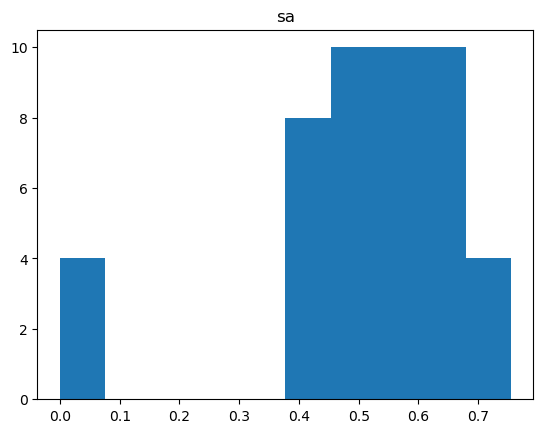

In [24]:
fig, ax = plt.subplots()
i = 19
ax.hist(section_nparrays[i])
plt.title(names[i])

plt.show()

## Cross-dataset Distances

In [9]:
cross_angles = np.random.rand(len(names), len(names))
for i, name1 in enumerate(names):
    for j, name2 in enumerate(names):
        n1 = split_dfs[i].shape[0]
        n2 = split_dfs[j].shape[0]
        array = np.empty(n1*n2)
        np_i = 0
        for row_i in split_dfs[i].index:
            for row_j in split_dfs[j].index:
                array[np_i] = query_matrix(angles_matrix,row_i,row_j)
                np_i+=1
        cross_angles[i, j] = np.nanmin(array)

In [22]:
for i, a in enumerate(section_nparrays):
    cross_angles[i,i] = np.nanmax(a)

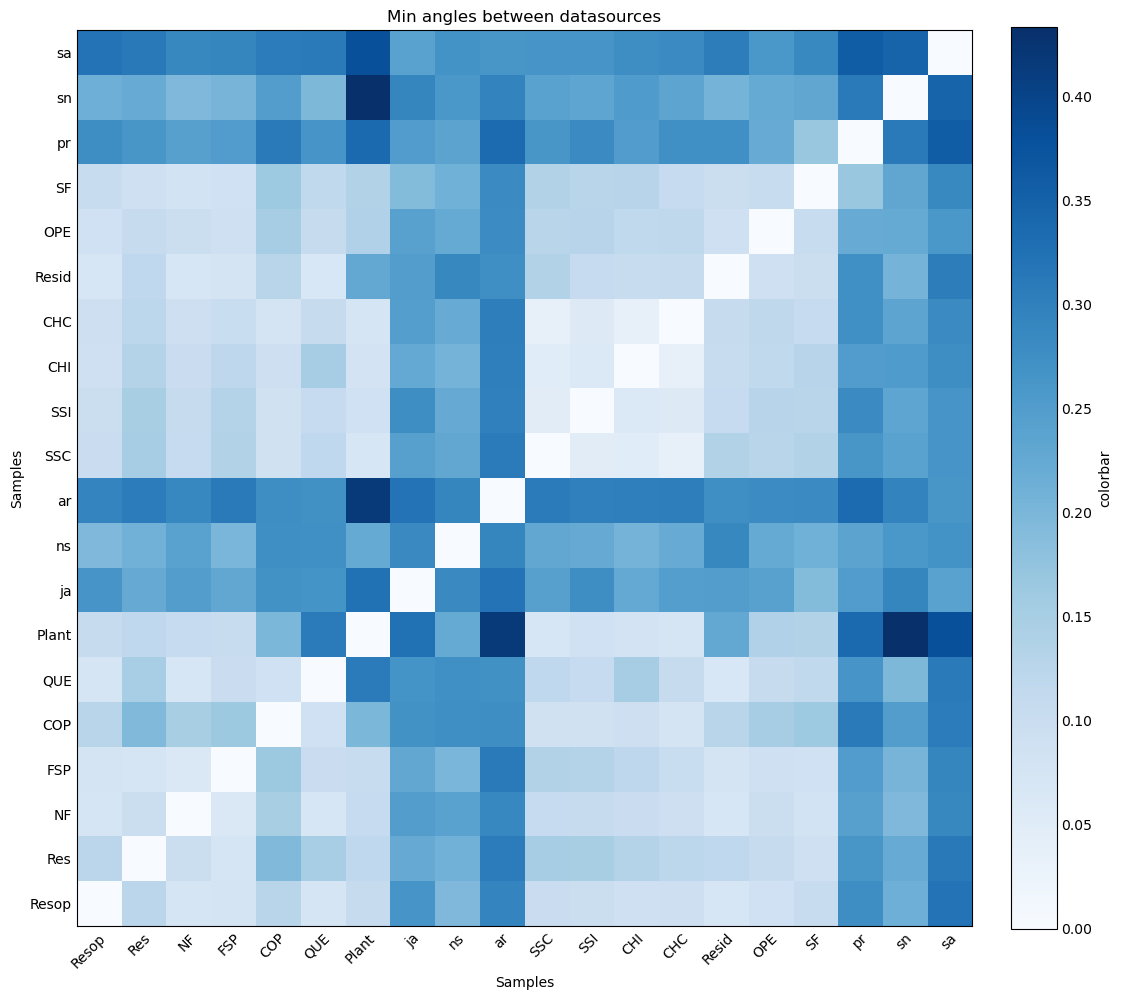

In [27]:
spectral_library.plot_matrix(cross_angles, title="Min angles between datasources",x_labels=names,y_labels=names)

In [7]:
random_subset = df.sample(100)

Text(0.5, 0, '1410')

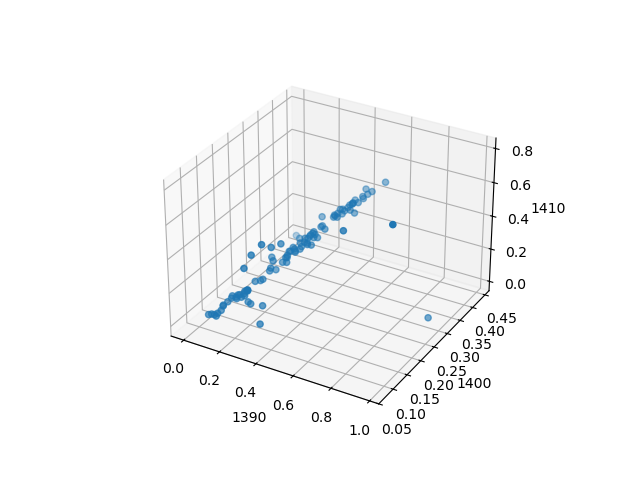

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_wave = wavelengths[99]
y_wave = wavelengths[100]
z_wave = wavelengths[101]

xs = random_subset[x_wave]
zs = random_subset[y_wave]
ys = random_subset[z_wave]
ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel(x_wave)
ax.set_ylabel(y_wave)
ax.set_zlabel(z_wave)

## Nearest Neighbor

In [27]:
import scipy

In [28]:
npv_fractions, numeric_data, _ = spectral_library.take_subset(df,start=900,end=1700)

In [29]:
sample = numeric_data.sample(100)

In [ ]:
neighbors = sklearn.neighbors.NearestNeighbors()

In [ ]:
    neighbors.fit(sample)

,n_neighbors,5
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,None


In [32]:
neighbors.kneighbors([sample.iloc[0]])

/Users/andrei/.local/share/mamba/envs/plswork/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.        , 0.09905174, 0.10449208, 0.1453204 , 0.15538437]]),
 array([[ 0,  7, 12, 35, 32]]))

In [37]:
# load in the distances_matrix
samples = 1723
distances = np.load("intermediate_calculations/distances.npy")
distances_matrix = distances.reshape(samples,samples)

In [38]:
def get_closest_indexes(matrix,exclude_selfentries=True):
    modded_matrix = matrix
    if exclude_selfentries:
        modded_matrix = matrix.copy()
        for i in range(len(modded_matrix)):
            modded_matrix[i][i] = np.inf
    closest_indexes = [np.argmin(a) for a in modded_matrix]
    return closest_indexes

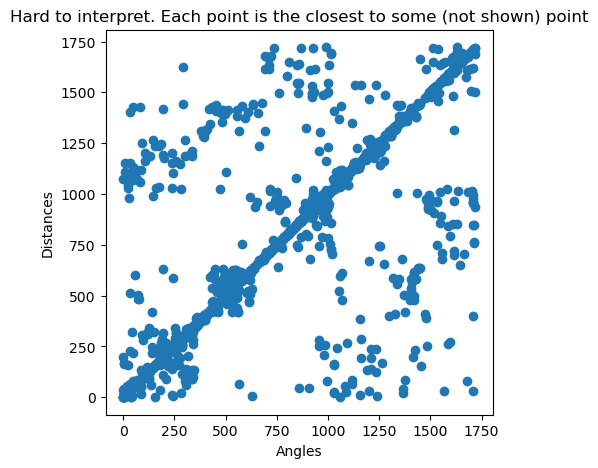

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel("Angles")
ax.set_ylabel("Distances")
ax.set_title(f"Hard to interpret. Each point is the closest to some (not shown) point")
ax.scatter(get_closest_indexes(angles_matrix),get_closest_indexes(distances_matrix))
print()

Text(0.5, 0, 'Index')

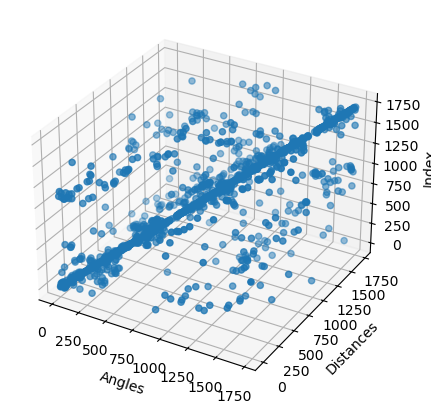

In [42]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

xs = get_closest_indexes(angles_matrix)
zs = get_closest_indexes(distances_matrix)
ys = range(0,samples)
ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel("Angles")
ax.set_ylabel("Distances")
ax.set_zlabel("Index")

In [68]:
closest_indexes = get_closest_indexes(distances_matrix)

In [69]:
closest_distances = np.fromiter((query_matrix(distances_matrix,reference=i,target=closest_indexes[i]) for i in range(samples)),dtype=np.float64)
closest_distances = np.nan_to_num(closest_distances)

In [70]:
expected_npvs = np.fromiter((df['npv_fraction'][i] for i in range(samples)),dtype=np.float64)
predicted_npvs = np.fromiter((df['npv_fraction'][closest_indexes[i]] for i in range(samples)),dtype=np.float64)

In [75]:
npv_residuals = np.abs(expected_npvs - predicted_npvs)

In [76]:
reg = spectral_library.train_linear_model(expected_npvs.reshape(-1, 1),predicted_npvs.reshape(-1, 1))
reg.score(expected_npvs.reshape(-1, 1),predicted_npvs.reshape(-1, 1))

0.5443194329205933

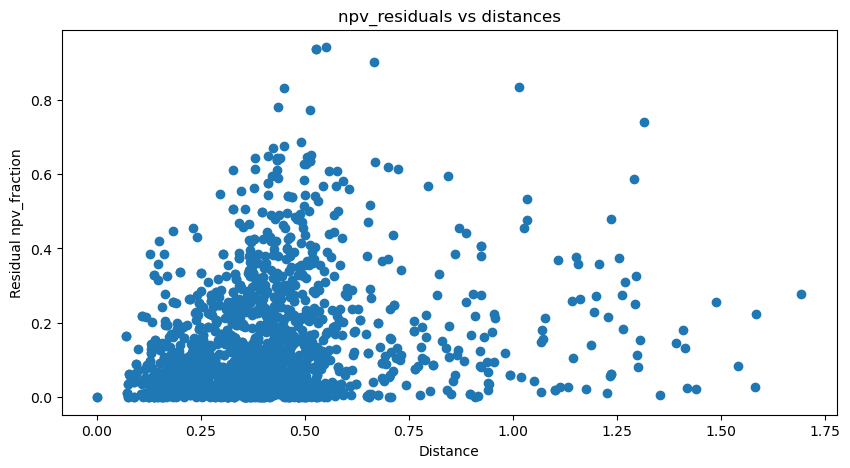

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Distance")
ax.set_ylabel("Residual npv_fraction")
ax.set_title(f"npv_residuals vs distances")
ax.scatter(closest_distances, npv_residuals)
print()

In [55]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=1)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    ax_histx.hist(x, bins=100)
    ax_histy.hist(y, bins=100, orientation='horizontal')

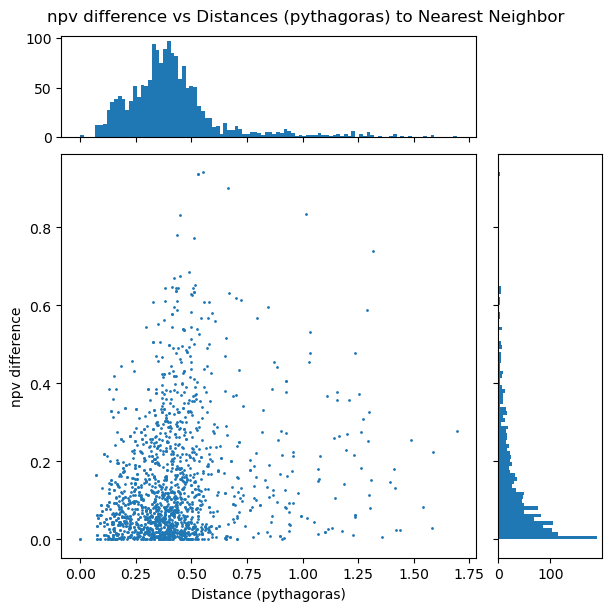

In [79]:
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')
scatter_hist(closest_distances, npv_residuals, axs['scatter'], axs['histx'], axs['histy'])
plt.suptitle("npv difference vs Distances (pythagoras) to Nearest Neighbor")
axs['scatter'].set_xlabel("Distance (pythagoras)")
axs['scatter'].set_ylabel("npv difference")
print()

In [24]:
diffs = []
for i in range(samples):
    diffs.append(df['npv_fraction'][i] - df['npv_fraction'][closest_indexes[i]])

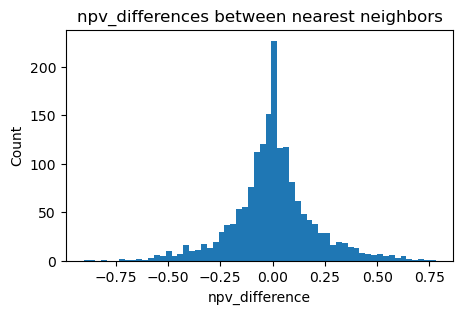

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("npv_difference")
ax.set_ylabel("Count")
ax.set_title(f"npv_differences between nearest neighbors")
ax.hist(diffs,bins=60)
print()

NameError: name 'closest_distances' is not defined

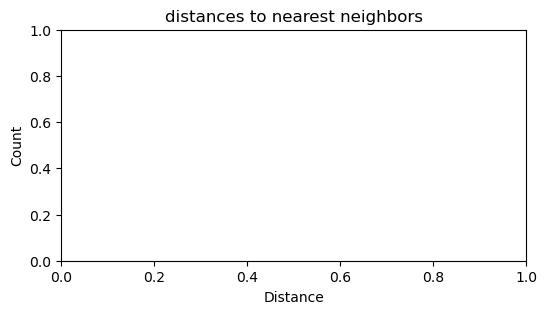

In [25]:
# plot distances
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlabel("Distance")
ax.set_ylabel("Count")
ax.set_title(f"distances to nearest neighbors")
ax.hist(closest_distances,bins=100)
print()

## Expected Extrapolation

In [26]:
fake_target_points_N = 100
fake_target_points_sample_size = 10
fake_target_points = pd.concat([numeric_data.sample(fake_target_points_sample_size).mean().to_frame().T for i in range(fake_target_points_N)],ignore_index=True)

NameError: name 'numeric_data' is not defined

In [190]:
fake_target_points

,400,410,420,430,440,450,460,470,480,490,...,2400,2410,2420,2430,2440,2450,2460,2470,2480,2490
0,0.042460,0.044513,0.047497,0.051148,0.054710,0.057796,0.060359,0.062607,0.065000,0.067750,...,0.197002,0.187678,0.189246,0.182245,0.174188,0.176518,0.175315,0.196023,0.228142,0.280695
1,0.024092,0.025637,0.027355,0.029444,0.031759,0.033814,0.035230,0.036195,0.037239,0.038506,...,0.085262,0.082453,0.069643,0.069879,0.073146,0.063806,0.061930,0.060698,0.110639,0.153659
2,0.046999,0.050281,0.053846,0.057850,0.061932,0.065404,0.067891,0.069952,0.072402,0.075693,...,0.226968,0.228598,0.217880,0.205641,0.190948,0.172772,0.190974,0.197104,0.152944,0.115663
3,0.054463,0.056618,0.059556,0.062674,0.066086,0.069178,0.071481,0.073371,0.075380,0.077938,...,0.177715,0.173511,0.169002,0.160908,0.150965,0.158420,0.152559,0.136695,0.196420,0.107138
4,0.044238,0.046716,0.049650,0.053041,0.056400,0.059232,0.061537,0.063562,0.065733,0.068234,...,0.185885,0.187887,0.181908,0.177880,0.170431,0.158842,0.161959,0.151001,0.205992,0.258043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.035926,0.038235,0.040695,0.043454,0.046111,0.048421,0.050364,0.051994,0.053617,0.055363,...,0.145661,0.141052,0.138446,0.133497,0.125441,0.122139,0.117383,0.126573,0.205794,0.180039
96,0.033368,0.035446,0.037923,0.040883,0.043957,0.046788,0.048930,0.050460,0.052034,0.053895,...,0.132435,0.129156,0.126089,0.121704,0.128980,0.134626,0.127181,0.151103,0.243726,0.184934
97,0.030985,0.033535,0.036604,0.040047,0.043692,0.047106,0.049951,0.052305,0.054772,0.057668,...,0.153573,0.147217,0.138268,0.139460,0.133925,0.120766,0.123110,0.127134,0.147583,0.108125
98,0.026099,0.027767,0.029793,0.032035,0.034363,0.036413,0.038062,0.039466,0.040872,0.042367,...,0.105443,0.096004,0.091439,0.084996,0.090934,0.082875,0.094980,0.118024,0.154043,0.241444


In [191]:
distances = calculate_distance_matrix(numeric_data,fake_target_points)

In [192]:
closest_i = get_closest_indexes(distances.reshape(fake_target_points_N,samples), exclude_selfentries=False)

Hello


In [186]:
closest_i

[np.int64(568),
 np.int64(159),
 np.int64(1297),
 np.int64(1023),
 np.int64(1431),
 np.int64(1280),
 np.int64(160),
 np.int64(1209),
 np.int64(160),
 np.int64(1024),
 np.int64(1024),
 np.int64(1024),
 np.int64(1280),
 np.int64(1297),
 np.int64(1089),
 np.int64(3),
 np.int64(1089),
 np.int64(1089),
 np.int64(1024),
 np.int64(1089)]

In [193]:
diffs = []
for i in range(fake_target_points_N):
    diffs.append(query_matrix(distances.reshape(fake_target_points_N,samples),i,closest_i[i]))

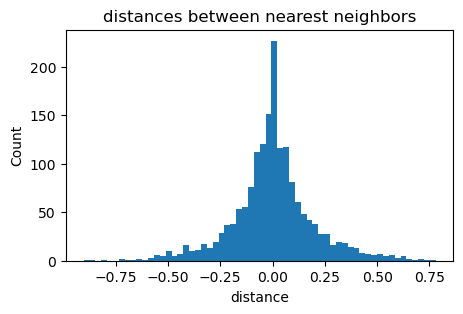

In [46]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("distance")
ax.set_ylabel("Count")
ax.set_title(f"distances between nearest neighbors")
ax.hist(diffs,bins=60)
print()